In [1]:
import torch,os
import torch.nn as nn
from torchvision import datasets,models,transforms
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [2]:
n_workers = 0
n_batch = 32
base_dir = '../data/'

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.CenterCrop(224),                                       
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),normalize]
                                       ) 

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),normalize])


train_dataset = datasets.ImageFolder(os.path.join(base_dir,'train'),train_transforms)
valid_dataset = datasets.ImageFolder(os.path.join(base_dir,'valid'),test_transforms)
test_dataset = datasets.ImageFolder(os.path.join(base_dir,'test'),test_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=n_batch,shuffle=True,num_workers=n_workers)
validation_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=n_batch,shuffle=True,num_workers=n_workers)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=n_batch,shuffle=False,num_workers=n_workers)
loader = {'train':train_loader,'valid':validation_loader,'test':test_loader}

In [675]:
train_dataset.class_to_idx

{'melanoma': 0, 'nevus': 1, 'seborrheic_keratosis': 2}

In [3]:
# number of classes

n_output = len(train_dataset.classes)


In [44]:
n_output

3

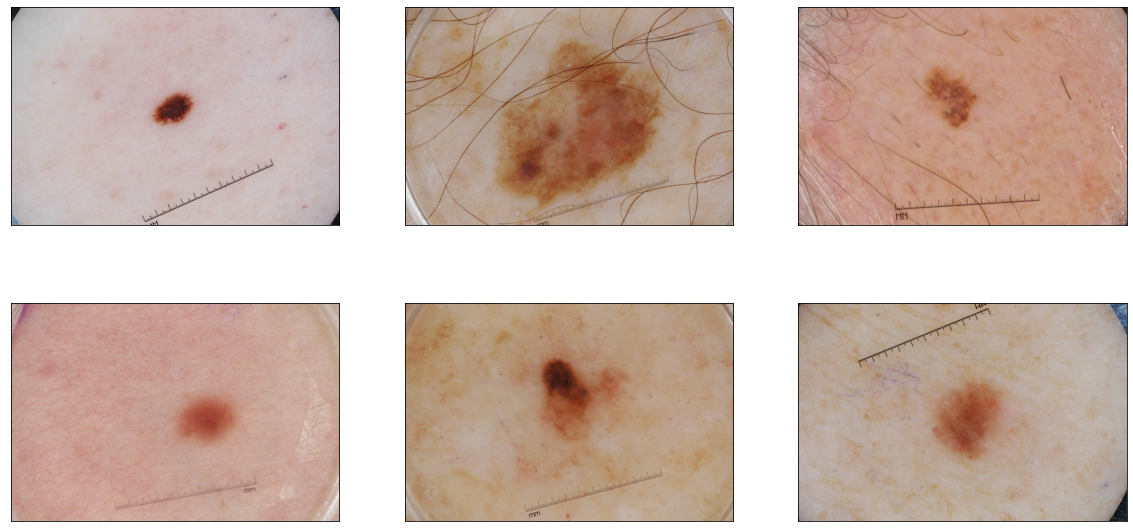

In [4]:
fig = plt.figure(figsize=(20,10))
for i,img in enumerate(valid_dataset.samples[:6]):
    ax = fig.add_subplot(2,3,i+1,xticks=[],yticks=[])
    img = Image.open(img[0])
    ax.imshow(img)

    

In [4]:
model = models.resnet18(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
for i,layers in enumerate(model.children()):
    if i < 9:
        for param in layers.parameters():
            param.requires_grad = False

In [6]:
model.fc = nn.Linear(model.fc.in_features,n_output)        

In [7]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
## define criterion and optimizer function

device = 'cuda' if torch.cuda.is_available() else 'cpu'

device = torch.device(device)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(),weight_decay=1e-4)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

In [9]:
device

device(type='cuda')

In [52]:
torch.cuda.empty_cache()

In [25]:
## define train function

def train(n_epochs,loader,model,criterion,optimizer,device):
    
    valid_loss_min = np.inf
    for epoch in range(1,n_epochs+1):
        gc.collect()
        torch.cuda.empty_cache()
        
        #scheduler.step()
        train_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch_idx,(data,target) in enumerate(loader['train']):
            #if batch_idx == 30:
             #   break
            optimizer.zero_grad()
            ## find the loss and update the model parameters accordingly
            output = model(data.to(device))
            loss = criterion(output,target.to(device))
            loss.backward()
            optimizer.step()
            train_loss += (1/(batch_idx+1))*(loss.item() - train_loss)
            print("train_loss in batch {}: {:.6f}".format(batch_idx,train_loss))
            
        with torch.no_grad():
            model.eval()
            for batch_idx,(data,target) in enumerate(loader['valid']):
                output = model(data.to(device))
                loss = criterion(output,target.to(device))
                ## update the average validation loss
                valid_loss += (1/(batch_idx+1))*(loss.item() - valid_loss)
                print("valid_loss in batch {} : {:.6f}".format(batch_idx,valid_loss))
            
         # print training/validation statistics         
        print("Epoch:{} \t train_loss:{:.6f}\t valid_loss:{:.6f}".format(epoch,train_loss,valid_loss))
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print("validation loss decreased from {:.6f} to {:.6f}.Saving model...".format(valid_loss_min,valid_loss))
            torch.save(model.state_dict(),'model.pth')
            valid_loss_min = valid_loss
                                                        
    return model        
    

NameError: name 'valid_loss_min' is not defined

In [24]:
## train the model
model = train(5,loader,model,criterion,optimizer,device)

train_loss in batch 0: 0.751200
train_loss in batch 1: 0.732570
train_loss in batch 2: 0.712579
train_loss in batch 3: 0.743787
train_loss in batch 4: 0.762685
train_loss in batch 5: 0.777944
train_loss in batch 6: 0.785439
train_loss in batch 7: 0.777498
train_loss in batch 8: 0.781844
train_loss in batch 9: 0.773025
train_loss in batch 10: 0.767260
train_loss in batch 11: 0.763239
train_loss in batch 12: 0.766369
train_loss in batch 13: 0.764040
train_loss in batch 14: 0.768207
train_loss in batch 15: 0.767319
train_loss in batch 16: 0.759686
train_loss in batch 17: 0.757647
train_loss in batch 18: 0.757425
train_loss in batch 19: 0.749837
train_loss in batch 20: 0.762159
train_loss in batch 21: 0.758056
train_loss in batch 22: 0.756752
train_loss in batch 23: 0.762889
train_loss in batch 24: 0.755226
train_loss in batch 25: 0.752184
train_loss in batch 26: 0.749020
train_loss in batch 27: 0.749309
train_loss in batch 28: 0.749271
train_loss in batch 29: 0.753681
train_loss in batch 

train_loss in batch 41: 0.696583
train_loss in batch 42: 0.691534
train_loss in batch 43: 0.693959
train_loss in batch 44: 0.691568
train_loss in batch 45: 0.695525
train_loss in batch 46: 0.695018
train_loss in batch 47: 0.694223
train_loss in batch 48: 0.690168
train_loss in batch 49: 0.686888
train_loss in batch 50: 0.686626
train_loss in batch 51: 0.682642
train_loss in batch 52: 0.682651
train_loss in batch 53: 0.685730
train_loss in batch 54: 0.684127
train_loss in batch 55: 0.680384
train_loss in batch 56: 0.683204
train_loss in batch 57: 0.684192
train_loss in batch 58: 0.680838
train_loss in batch 59: 0.680798
train_loss in batch 60: 0.681526
train_loss in batch 61: 0.678753
train_loss in batch 62: 0.679708
valid_loss in batch 0 : 1.029889
valid_loss in batch 1 : 1.011934
valid_loss in batch 2 : 1.042652
valid_loss in batch 3 : 1.083680
valid_loss in batch 4 : 1.043758
Epoch:4 	 train_loss:0.679708	 valid_loss:1.043758
train_loss in batch 0: 0.550015
train_loss in batch 1: 0.6

In [642]:
## load the model 

model.load_state_dict(torch.load('model.pth',map_location = lambda storage, loc: storage));

In [51]:
import glob


test_files1 = glob.glob("../data/test/*/*")
test_files = [ path.lstrip('../').replace('\\','/') for path in test_files1 ]
test_files = np.array(test_files)[:,None]


In [15]:
## define test function

def test(model,criterion,loader,device):
    results=[] 
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for batch_idx,(data,target) in enumerate(loader['test']):
            if batch_idx == 4:
                break
            output = model(data.to(device))
            print(target)
            loss = criterion(output,target.to(device))
             # update average test loss 
            test_loss += (1/(batch_idx+1))*(loss.item() - test_loss)

             # convert output probabilities to predicted class
            _,preds = torch.max(output,1,keepdim=True)
            results.append(F.softmax(output.to(torch.device('cpu')),dim=1))          
            
             # compare predictions to true label
            preds = preds.to(torch.device('cpu'))
            
            correct += np.sum(np.squeeze(preds.eq(target.view_as(preds))).numpy())
            total += data.size(0)
    print("test loss {:.6f}".format(test_loss))
    print("accuracy: {} {}/{} ".format((correct/total)*100,correct,total))
    results = torch.vstack(results)
    return results


In [26]:
raw_results = test(model,criterion,loader,device)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
test loss 1.897596
accuracy: 10.9375 14/128 


In [317]:
results = raw_results.numpy()

In [ ]:
results1=[]
correct=0
total=0
with torch.no_grad():
    model.eval()
    for i in range(1,101):
        data,target = next(iter(loader['test']))
        print("{} {}".format(i,target))
        output = model(data.to(device))            
        # convert output probabilities to predicted class
        _,preds = torch.max(output,1,keepdim=True)
        preds = preds.to(torch.device('cpu'))
        correct += np.sum(np.squeeze(preds.eq(target.view_as(preds))).numpy())
        total += data.size(0)
        results1.append(output.to(torch.device('cpu')))         
   
    print("accuracy: {} {}/{} ".format((correct/total)*100,correct,total))       
          

In [645]:
def predict(img_path):
 
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    img = Image.open(img_path)
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),normalize])

    
    img = transform(img)
    img = img.unsqueeze_(0)
    img = img.to(device)
  
    with torch.no_grad():
        
        model.eval()
        output = F.softmax(model(img),dim=1)
        
       
    #print(top_class,top_index)
    return output.max(1)[1].item() # predicted class index

In [240]:
test_files1[1]

'../data/test\\melanoma\\ISIC_0012356.jpg'

In [247]:
predict(test_files1[5])

1

In [42]:
results1[0].max(1,keepdim=True)[1].squeeze()

tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 0])

In [43]:
results1[1].max(1,keepdim=True)[1].squeeze()

tensor([2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 0, 1])

In [45]:
F.softmax(results1[0],dim=1)

tensor([[2.4139e-02, 9.7586e-01, 4.8631e-06],
        [1.7139e-02, 9.7924e-01, 3.6232e-03],
        [1.3774e-01, 5.8533e-01, 2.7693e-01],
        [1.5053e-01, 5.8565e-01, 2.6382e-01],
        [7.9306e-01, 1.1973e-01, 8.7206e-02],
        [9.1146e-02, 8.9496e-01, 1.3896e-02],
        [4.0321e-01, 4.8504e-01, 1.1175e-01],
        [1.8492e-02, 9.7898e-01, 2.5317e-03],
        [2.2548e-01, 7.3408e-01, 4.0443e-02],
        [1.6974e-01, 3.4499e-01, 4.8527e-01],
        [4.0871e-02, 9.2733e-01, 3.1800e-02],
        [1.0637e-01, 2.8220e-01, 6.1144e-01],
        [7.1189e-02, 9.2730e-01, 1.5090e-03],
        [5.9886e-04, 3.8538e-02, 9.6086e-01],
        [3.4995e-01, 6.4401e-01, 6.0395e-03],
        [3.6589e-02, 9.5214e-01, 1.1266e-02],
        [6.2763e-02, 8.9427e-01, 4.2968e-02],
        [2.7460e-01, 6.4717e-01, 7.8224e-02],
        [4.2081e-01, 5.6708e-01, 1.2107e-02],
        [4.7157e-01, 4.0429e-01, 1.2414e-01]])

In [218]:
results = np.hstack((test_files,results))
results.shape

(600, 4)

In [219]:
pd.DataFrame(results,columns=['Id','task_1','task_2','task_3']).to_csv('my_predictions.csv',columns=['Id','task_1','task_3'],
                                 header=['Id','task_1','task_2'],index=False)